In [5]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels
y_test.shape, y_val.shape, y_train.shape

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


((10000,), (5000,), (55000,))

In [6]:
# Pre-processing
def prepro(X_train, X_val, X_test):
    mean = np.mean(X_train)
    # scale = 255. - mean # std or sqrt(var), 255 == 2**8 or 8 bit grayscale
    # return (X_train - mean)/ scale, (X_val - mean)/ scale, (X_test - mean) / scale
    return X_train - mean, X_val - mean, X_test - mean

X_train, X_val, X_test = prepro(X_train, X_val, X_test)

In [14]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        # self.mode = 'classification'
        self.L = L # number of layers or depth
        self.losses = {'train':[], 'smooth train':[], 'valid':[], 'valid_acc':[]}
        
        # The adaptive/learnable/updatable random feedforward
        self.model = []
        self.W_fixed = []
        
        # Input layer
        m = dict(W=np.random.randn(D, H) / np.sqrt(D / 2.),
                 b=np.zeros((1, H)))
        #         low, high = (-1. / np.sqrt(D / 2.)), (+1. / np.sqrt(D / 2.))
        #         m = dict(W=np.random.uniform(size=(D, H), low=low, high=high),
        #                  b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        #         m = np.random.uniform(size=(D, H), low=low, high=high)
        m = np.random.randn(D, H) / np.sqrt(D / 2.)
        self.W_fixed.append(m)

        # Hidden layers
        m = dict(W=np.random.randn(H, H) / np.sqrt(H / 2.),
                 b=np.zeros((1, H)))
        #         low, high = (-1. / np.sqrt(H / 2.)), (+1. / np.sqrt(H / 2.))
        #         m = dict(W=np.random.uniform(size=(H, H), low=low, high=high),
        #                  b=np.zeros((1, H)))
        m_L = []
        for _ in range(L):
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        #         m = np.random.uniform(size=(H, H), low=low, high=high)
        m = np.random.randn(H, H) / np.sqrt(H / 2.)
        m_L = []
        for _ in range(L):
            m_L.append(m)
        self.W_fixed.append(m_L)
        
        # Output layer
        m = dict(W=np.random.randn(H, C) / np.sqrt(H / 2.),
                 b=np.zeros((1, C)))
        #         low, high = (-1. / np.sqrt(H / 2.)), (+1. / np.sqrt(H / 2.))
        #         m = dict(W=np.random.uniform(size=(H, C), low=low, high=high),
        #                  b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        #         m = np.random.uniform(size=(H, C), low=low, high=high)
        m = np.random.randn(H, C) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        # dX = dout @ W.T # Backprop
        dX = dout @ W_fixed.T # fb alignment

        return dX, dW, db

    def train_forward(self, X):
        caches = []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, nl_cache = selu_forward(X=y)
        X = y.copy() # pass the previous output to the next layer
        caches.append((fc_cache, nl_cache)) # caches[0]
        
        # Hidden layers
        fc_caches, nl_caches = [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, nl_cache = selu_forward(X=y)
            X = y.copy() # pass to next layer
            fc_caches.append(fc_cache)
            nl_caches.append(nl_cache)
        caches.append((fc_caches, nl_caches)) # caches[1]
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        caches.append(fc_cache) # caches[2]

        return y, caches

    def loss_function(self, y, y_train):
        
        loss = cross_entropy(y, y_train) # softmax is included
        dy = dcross_entropy(y, y_train) # dsoftmax is included
        
        return loss, dy
    
    def train_backward(self, dy, caches):
        grads = []

        # Input layer
        grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
        
        # Hidden layer
        grad = []
        for layer in range(self.L):
            grad.append({key: np.zeros_like(val) for key, val in self.model[1][layer].items()})
        grads.append(grad)

        # Outout layer
        grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})

        # Output layer
        fc_cache = caches[2]
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy() # pass it to the previous layer
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
            dy = selu_backward(dout=dy, cache=nl_caches[layer])
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dy = dX.copy()
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache, nl_cache = caches[0]
        dy = selu_backward(dout=dy, cache=nl_cache)
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return dX, grads
    
    def test(self, X):
        y_logit, _ = self.train_forward(X)
        
        # if self.mode == 'classification':
        y_prob = l.softmax(y_logit) # for accuracy== acc
        y_pred = np.argmax(y_prob, axis=1) # for loss==err
        
        return y_pred, y_logit
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def adam(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Momentums
        M, R = [], []

        # Input layer momentums
        M.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
        R.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden layers momentum
        M_, R_ = [], []
        for layer in range(self.L):
            M_.append({key: np.zeros_like(val) for key, val in self.model[1][layer].items()})
            R_.append({key: np.zeros_like(val) for key, val in self.model[1][layer].items()})
        M.append(M_)
        R.append(R_)

        # Output layer momentums
        M.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        R.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
 
        # Learning decay
        beta1 = .9
        beta2 = .99
        smooth_train = 1.

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            #         """
            #         Single training step over minibatch: forward, loss, backprop
            #         """
            # Shuffle for each epochs/ stochasticity/ randomly choosing
            #             for idx in range(len(minibatches)):
            #             for _ in range(10):
            # Shuffle in every iteration
            # The dataset is static and non-sequentiol: no time-dependency or temporal pattern
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y, caches = self.train_forward(X_mini)
            loss, dy = self.loss_function(y, y_mini)
            _, grads = self.train_backward(dy, caches)
            self.losses['train'].append(loss)
            smooth_train = (0.999 * smooth_train) + (0.001 * loss)
            self.losses['smooth train'].append(smooth_train)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]
                # M[0][key] = l.exp_running_avg(M[0][key], grads[0][key], beta1)
                # R[0][key] = l.exp_running_avg(R[0][key], grads[0][key]**2, beta2)
                # m_k_hat = M[0][key] / (1. - (beta1**(iter)))
                # r_k_hat = R[0][key] / (1. - (beta2**(iter)))
                # self.model[0][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]
                    # M[1][layer][key] = l.exp_running_avg(M[1][layer][key], grads[1][layer][key], beta1)
                    # R[1][layer][key] = l.exp_running_avg(R[1][layer][key], grads[1][layer][key]**2, beta2)
                    # m_k_hat = M[1][layer][key] / (1. - (beta1**(iter)))
                    # r_k_hat = R[1][layer][key] / (1. - (beta2**(iter)))
                    # self.model[1][layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)


            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
                # M[2][key] = l.exp_running_avg(M[2][key], grads[2][key], beta1)
                # R[2][key] = l.exp_running_avg(R[2][key], grads[2][key]**2, beta2)
                # m_k_hat = M[2][key] / (1. - (beta1**(iter)))
                # r_k_hat = R[2][key] / (1. - (beta2**(iter)))
                # self.model[2][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

            # Validate the updated model
            y_pred, y_logit = self.test(X_val)
            valid_loss, _ = self.loss_function(y_logit, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val)
            self.losses['valid_acc'].append(valid_acc)
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{} train loss: {:.4f} valid loss: {:.4f}, valid accuracy: {:.4f}'.format(
                    iter, loss, valid_loss, valid_acc))

        # Test the final model
        y_pred, y_logit = nn.test(X_test)
        loss, _ = self.loss_function(y_logit, y_test) # softmax is included in entropy loss function
        acc = np.mean(y_pred == y_test)
        print('Last iteration - Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.format(
            acc.mean(), acc.std(), loss))

In [15]:
# Hyper-parameters
n_iter = 10000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 64 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 1 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.adam(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-10 train loss: 2.8678 valid loss: 2.9427, valid accuracy: 0.0498
Iter-20 train loss: 2.8740 valid loss: 2.9321, valid accuracy: 0.0516
Iter-30 train loss: 2.8428 valid loss: 2.9205, valid accuracy: 0.0524
Iter-40 train loss: 2.9644 valid loss: 2.9108, valid accuracy: 0.0526
Iter-50 train loss: 2.8272 valid loss: 2.8996, valid accuracy: 0.0526
Iter-60 train loss: 3.0085 valid loss: 2.8892, valid accuracy: 0.0530
Iter-70 train loss: 2.8316 valid loss: 2.8803, valid accuracy: 0.0526
Iter-80 train loss: 2.9764 valid loss: 2.8718, valid accuracy: 0.0528
Iter-90 train loss: 2.6769 valid loss: 2.8647, valid accuracy: 0.0534
Iter-100 train loss: 2.8713 valid loss: 2.8566, valid accuracy: 0.0530
Iter-110 train loss: 2.7562 valid loss: 2.8502, valid accuracy: 0.0534
Iter-120 train loss: 2.8034 valid loss: 2.8467, valid accuracy: 0.0522
Iter-130 train loss: 2.9874 valid loss: 2.8380, valid accuracy: 0.0526
Iter-140 train loss: 2.9532 valid loss: 2.8310, valid accuracy: 0.0518
Iter-150 train 

Iter-1170 train loss: 1.6600 valid loss: 1.7906, valid accuracy: 0.3502
Iter-1180 train loss: 1.7591 valid loss: 1.7822, valid accuracy: 0.3558
Iter-1190 train loss: 1.7912 valid loss: 1.7742, valid accuracy: 0.3620
Iter-1200 train loss: 1.5294 valid loss: 1.7659, valid accuracy: 0.3662
Iter-1210 train loss: 1.7213 valid loss: 1.7572, valid accuracy: 0.3722
Iter-1220 train loss: 1.7796 valid loss: 1.7485, valid accuracy: 0.3776
Iter-1230 train loss: 1.6736 valid loss: 1.7397, valid accuracy: 0.3834
Iter-1240 train loss: 1.8302 valid loss: 1.7304, valid accuracy: 0.3894
Iter-1250 train loss: 1.8924 valid loss: 1.7226, valid accuracy: 0.3948
Iter-1260 train loss: 1.7685 valid loss: 1.7146, valid accuracy: 0.3980
Iter-1270 train loss: 1.6990 valid loss: 1.7058, valid accuracy: 0.4044
Iter-1280 train loss: 1.4708 valid loss: 1.6978, valid accuracy: 0.4098
Iter-1290 train loss: 1.7026 valid loss: 1.6901, valid accuracy: 0.4124
Iter-1300 train loss: 1.6913 valid loss: 1.6821, valid accuracy:

Iter-2310 train loss: 1.3417 valid loss: 1.1017, valid accuracy: 0.6444
Iter-2320 train loss: 1.1316 valid loss: 1.0978, valid accuracy: 0.6454
Iter-2330 train loss: 1.0463 valid loss: 1.0940, valid accuracy: 0.6476
Iter-2340 train loss: 1.1521 valid loss: 1.0903, valid accuracy: 0.6504
Iter-2350 train loss: 1.0346 valid loss: 1.0863, valid accuracy: 0.6504
Iter-2360 train loss: 0.9417 valid loss: 1.0835, valid accuracy: 0.6516
Iter-2370 train loss: 0.9003 valid loss: 1.0798, valid accuracy: 0.6538
Iter-2380 train loss: 1.1376 valid loss: 1.0760, valid accuracy: 0.6552
Iter-2390 train loss: 1.0774 valid loss: 1.0728, valid accuracy: 0.6568
Iter-2400 train loss: 1.2727 valid loss: 1.0695, valid accuracy: 0.6580
Iter-2410 train loss: 1.0150 valid loss: 1.0662, valid accuracy: 0.6604
Iter-2420 train loss: 1.1242 valid loss: 1.0629, valid accuracy: 0.6608
Iter-2430 train loss: 1.0400 valid loss: 1.0594, valid accuracy: 0.6634
Iter-2440 train loss: 1.1204 valid loss: 1.0561, valid accuracy:

Iter-3450 train loss: 0.7596 valid loss: 0.8123, valid accuracy: 0.7546
Iter-3460 train loss: 0.8593 valid loss: 0.8105, valid accuracy: 0.7554
Iter-3470 train loss: 0.7231 valid loss: 0.8088, valid accuracy: 0.7562
Iter-3480 train loss: 0.9332 valid loss: 0.8070, valid accuracy: 0.7570
Iter-3490 train loss: 0.6309 valid loss: 0.8054, valid accuracy: 0.7578
Iter-3500 train loss: 0.7407 valid loss: 0.8035, valid accuracy: 0.7584
Iter-3510 train loss: 1.0173 valid loss: 0.8018, valid accuracy: 0.7592
Iter-3520 train loss: 0.9238 valid loss: 0.8003, valid accuracy: 0.7596
Iter-3530 train loss: 0.8270 valid loss: 0.7986, valid accuracy: 0.7594
Iter-3540 train loss: 0.9657 valid loss: 0.7969, valid accuracy: 0.7600
Iter-3550 train loss: 0.8410 valid loss: 0.7952, valid accuracy: 0.7612
Iter-3560 train loss: 0.7400 valid loss: 0.7937, valid accuracy: 0.7616
Iter-3570 train loss: 0.9227 valid loss: 0.7917, valid accuracy: 0.7626
Iter-3580 train loss: 0.9387 valid loss: 0.7902, valid accuracy:

Iter-4590 train loss: 0.5220 valid loss: 0.6682, valid accuracy: 0.8018
Iter-4600 train loss: 0.6101 valid loss: 0.6672, valid accuracy: 0.8024
Iter-4610 train loss: 0.5452 valid loss: 0.6664, valid accuracy: 0.8032
Iter-4620 train loss: 0.7157 valid loss: 0.6657, valid accuracy: 0.8038
Iter-4630 train loss: 0.6860 valid loss: 0.6648, valid accuracy: 0.8040
Iter-4640 train loss: 0.6017 valid loss: 0.6637, valid accuracy: 0.8044
Iter-4650 train loss: 0.6030 valid loss: 0.6630, valid accuracy: 0.8036
Iter-4660 train loss: 0.5693 valid loss: 0.6622, valid accuracy: 0.8042
Iter-4670 train loss: 0.6467 valid loss: 0.6612, valid accuracy: 0.8038
Iter-4680 train loss: 0.4874 valid loss: 0.6601, valid accuracy: 0.8040
Iter-4690 train loss: 0.6005 valid loss: 0.6592, valid accuracy: 0.8042
Iter-4700 train loss: 0.7667 valid loss: 0.6584, valid accuracy: 0.8042
Iter-4710 train loss: 0.8288 valid loss: 0.6573, valid accuracy: 0.8036
Iter-4720 train loss: 0.6439 valid loss: 0.6565, valid accuracy:

Iter-5730 train loss: 0.5935 valid loss: 0.5843, valid accuracy: 0.8248
Iter-5740 train loss: 0.7790 valid loss: 0.5837, valid accuracy: 0.8250
Iter-5750 train loss: 0.6441 valid loss: 0.5832, valid accuracy: 0.8256
Iter-5760 train loss: 0.6381 valid loss: 0.5827, valid accuracy: 0.8258
Iter-5770 train loss: 0.7397 valid loss: 0.5821, valid accuracy: 0.8254
Iter-5780 train loss: 0.6265 valid loss: 0.5815, valid accuracy: 0.8264
Iter-5790 train loss: 0.5745 valid loss: 0.5808, valid accuracy: 0.8262
Iter-5800 train loss: 0.5726 valid loss: 0.5802, valid accuracy: 0.8274
Iter-5810 train loss: 0.6612 valid loss: 0.5796, valid accuracy: 0.8272
Iter-5820 train loss: 0.5860 valid loss: 0.5792, valid accuracy: 0.8274
Iter-5830 train loss: 0.6484 valid loss: 0.5787, valid accuracy: 0.8272
Iter-5840 train loss: 0.5522 valid loss: 0.5781, valid accuracy: 0.8272
Iter-5850 train loss: 0.5492 valid loss: 0.5775, valid accuracy: 0.8264
Iter-5860 train loss: 0.4056 valid loss: 0.5768, valid accuracy:

Iter-6870 train loss: 0.4975 valid loss: 0.5304, valid accuracy: 0.8400
Iter-6880 train loss: 0.4401 valid loss: 0.5300, valid accuracy: 0.8394
Iter-6890 train loss: 0.5563 valid loss: 0.5298, valid accuracy: 0.8396
Iter-6900 train loss: 0.3821 valid loss: 0.5295, valid accuracy: 0.8398
Iter-6910 train loss: 0.4141 valid loss: 0.5291, valid accuracy: 0.8398
Iter-6920 train loss: 0.8608 valid loss: 0.5288, valid accuracy: 0.8398
Iter-6930 train loss: 0.5848 valid loss: 0.5283, valid accuracy: 0.8404
Iter-6940 train loss: 0.5032 valid loss: 0.5278, valid accuracy: 0.8398
Iter-6950 train loss: 0.5878 valid loss: 0.5276, valid accuracy: 0.8398
Iter-6960 train loss: 0.7785 valid loss: 0.5273, valid accuracy: 0.8404
Iter-6970 train loss: 0.5619 valid loss: 0.5267, valid accuracy: 0.8406
Iter-6980 train loss: 0.3878 valid loss: 0.5263, valid accuracy: 0.8402
Iter-6990 train loss: 0.6071 valid loss: 0.5259, valid accuracy: 0.8404
Iter-7000 train loss: 0.5577 valid loss: 0.5258, valid accuracy:

Iter-8010 train loss: 0.5117 valid loss: 0.4929, valid accuracy: 0.8538
Iter-8020 train loss: 0.5385 valid loss: 0.4926, valid accuracy: 0.8540
Iter-8030 train loss: 0.3371 valid loss: 0.4922, valid accuracy: 0.8538
Iter-8040 train loss: 0.5707 valid loss: 0.4919, valid accuracy: 0.8534
Iter-8050 train loss: 0.5963 valid loss: 0.4916, valid accuracy: 0.8536
Iter-8060 train loss: 0.5315 valid loss: 0.4913, valid accuracy: 0.8538
Iter-8070 train loss: 0.4368 valid loss: 0.4911, valid accuracy: 0.8538
Iter-8080 train loss: 0.5429 valid loss: 0.4907, valid accuracy: 0.8538
Iter-8090 train loss: 0.4245 valid loss: 0.4905, valid accuracy: 0.8542
Iter-8100 train loss: 0.6170 valid loss: 0.4901, valid accuracy: 0.8544
Iter-8110 train loss: 0.5624 valid loss: 0.4898, valid accuracy: 0.8542
Iter-8120 train loss: 0.5634 valid loss: 0.4895, valid accuracy: 0.8542
Iter-8130 train loss: 0.4665 valid loss: 0.4893, valid accuracy: 0.8540
Iter-8140 train loss: 0.6743 valid loss: 0.4891, valid accuracy:

Iter-9150 train loss: 0.6719 valid loss: 0.4652, valid accuracy: 0.8616
Iter-9160 train loss: 0.3615 valid loss: 0.4651, valid accuracy: 0.8614
Iter-9170 train loss: 0.5809 valid loss: 0.4648, valid accuracy: 0.8616
Iter-9180 train loss: 0.4907 valid loss: 0.4645, valid accuracy: 0.8618
Iter-9190 train loss: 0.3691 valid loss: 0.4644, valid accuracy: 0.8622
Iter-9200 train loss: 0.5910 valid loss: 0.4641, valid accuracy: 0.8622
Iter-9210 train loss: 0.3768 valid loss: 0.4640, valid accuracy: 0.8622
Iter-9220 train loss: 0.4390 valid loss: 0.4638, valid accuracy: 0.8622
Iter-9230 train loss: 0.3690 valid loss: 0.4637, valid accuracy: 0.8622
Iter-9240 train loss: 0.6202 valid loss: 0.4636, valid accuracy: 0.8618
Iter-9250 train loss: 0.5426 valid loss: 0.4633, valid accuracy: 0.8620
Iter-9260 train loss: 0.4318 valid loss: 0.4631, valid accuracy: 0.8622
Iter-9270 train loss: 0.4668 valid loss: 0.4629, valid accuracy: 0.8620
Iter-9280 train loss: 0.4538 valid loss: 0.4628, valid accuracy:

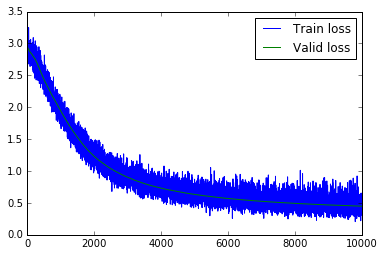

In [16]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
# plt.plot(nn.losses['smooth train'], label='Train smooth loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.legend()
plt.show()

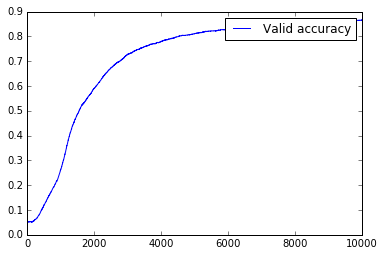

In [17]:
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.legend()
plt.show()